In [1]:
#import modules
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [2]:
def execQuery(query,*printOption):
    try:
        connection = psycopg2.connect(user = "postgres",
                                      password = "1234",
                                      host = "localhost",
                                      port = "5432",
                                      database = "FakeNews")
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL:", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            if not printOption:
                print("Executed query and closed connection.")

## Given an article by an author who have written for multiple domains, what is the probability that the article will belong to a certain domain type ('reliable', 'fake' etc)?

Let's define some events regarding some article in the dataset (in the probability theoric sense):

A: the article belongs to a specific domain type

B: the article was written by an author who has written articles for multiple domains.

What we are looking for is the conditional probability P(A|B), i.e. the probability that - given the article was written by an author who has written for multiple domains - this article belongs to some specific domain type. A conditional probability is defined as:

P(A|B) = P(A∩B)/P(B)

Looking at the righthand-side probabilites respectively (all articles weighing equally):

P(A∩B) = (number of articles where both A and B occured) / (total number of articles)

P(B) = (number of articles where B occured) / (total number of articles)

The conditional probability is then:

P(A|B) = (number of articles where both A and B occured) / (number of articles where B occured)

The denominator and numerator above can be found using the following query: 

In [3]:
#Numerator: listing, by domain type grouping, the number of articles written by authors 
#who have written for multiple domains
query4_1 = """
WITH author_mult AS(
SELECT author_id
FROM authors aus INNER JOIN
    article a USING (article_id) INNER JOIN
    domain d USING (domain_id)
GROUP BY (author_id)
HAVING (COUNT(DISTINCT domain_id)>1)
)

SELECT d.type, COUNT (distinct article_id) as cnt
FROM domain d INNER JOIN
    article a USING (domain_id) INNER JOIN
    authors aus USING (article_id) INNER JOIN
    author_mult au_m USING (author_id)
GROUP BY (d.type)
"""

res4_1 = execQuery(query4_1)
#gives the output
res4_1

Executed query and closed connection.


[('bias', 19523),
 ('clickbait', 4080),
 ('conspiracy', 7026),
 ('fake', 7104),
 ('hate', 835),
 ('junksci', 5094),
 ('political', 48528),
 ('reliable', 436),
 ('rumor', 1264),
 ('satire', 100),
 ('unreliable', 1815),
 (None, 18294)]

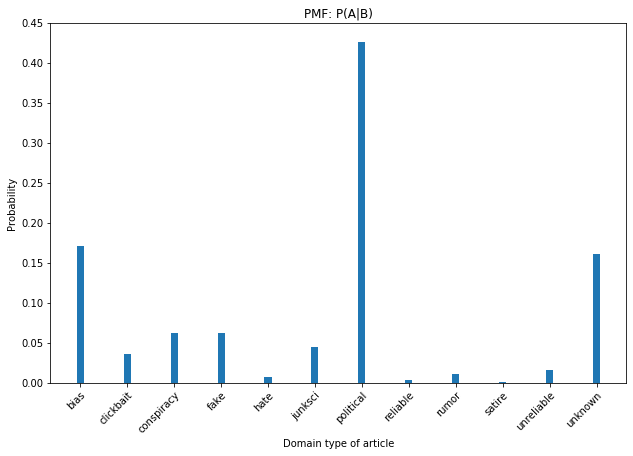

In [4]:
#Plotting the probability mass function for P(A|B)
if res4_1:
    total = sum(list(list(zip(*res4_1))[1])) #denominator
    
    types = list(map(lambda x: x[0] if x[0] else "unknown",res4_1))
    values = list(map(lambda x: x[1]/total,res4_1))
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(types,values,width=0.15)
    ax.set_xlabel('Domain type of article')
    ax.set_ylabel('Probability')
    ax.set_title('PMF: P(A|B)')
    ax.set_ylim([0.0,0.45])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

Executed query and closed connection.


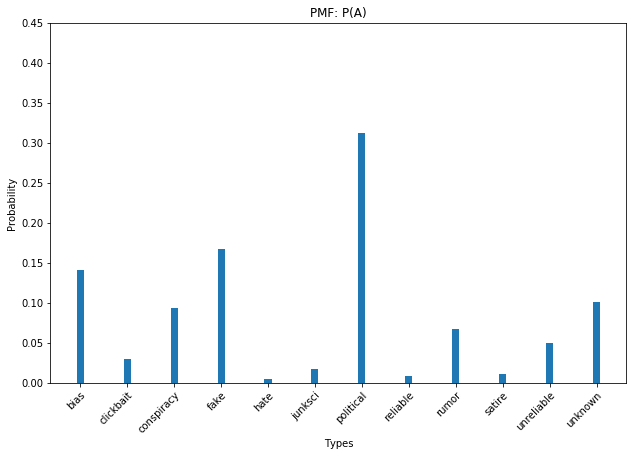

In [5]:
# Probability an article is of a certain type (all articles)
query9 = """
SELECT type, count(*)
FROM article
    INNER JOIN domain USING (domain_id)
GROUP BY type
"""
res9 = execQuery(query9)

if res9:
    sum9 = sum(list(list(zip(*res9))[1]))
    x = list(list(zip(*res9))[0])
    y = list(list(zip(*res9))[1])
    x = list(map(lambda z: z if z else 'unknown',x))
    y = list(map(lambda z: z/sum9,y))
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel('Types')
    ax.set_ylabel('Probability')
    ax.set_title('PMF: P(A)')
    ax.set_ylim([0.0,0.45])
    plt.bar(x,y,width=0.15)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

By comparing the two charts, it is seen that articles by authors, who have written for MORE than one domain, are less likely to be of types: conspiracy, fake, rumor, and unreliable.
## Simple analysis of text

In [6]:
#load data
filepath = '~/Documents/DataScience Notebooks/csv/1mio-clean.csv'
df = pd.read_csv(filepath,usecols=[3,5,10])
#drop NULL-types
df = df.drop(list(df.loc[pd.isna(df['type'])].index))
#drop type - content duplicates
df = df.drop_duplicates(subset=['type','content'])
#map to binary class
df['b_type'] = df['type'].apply(lambda x: 'FAKE' if x in ['fake','satire','bias','conspiracy','junksci'] else 'REAL')

In [7]:
#make list of authors
def makelist(x): return ast.literal_eval(x) if pd.notnull(x) else None
df['authors'] = df['authors'].apply(makelist)

In [8]:
# potential features
df['length'] = df.content.apply(len)
df['word_count'] = df.content.apply(lambda x: len(str(x).split()))
df['unique_word_count'] = df.content.apply(lambda x: len(set(str(x).split())))
df['mean_word_length'] = df.content.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df['author_count'] = df.authors.apply(lambda x: len(x) if x else 0)
df['number_count'] = df.content.apply(lambda x: len(re.findall('<NUM>',x)))
df['url_count'] = df.content.apply(lambda x: len(re.findall('<URL>',x)))
df['email_count'] = df.content.apply(lambda x: len(re.findall('<EMAIL>',x)))
df['date_count'] = df.content.apply(lambda x: len(re.findall('<DATE>',x)))

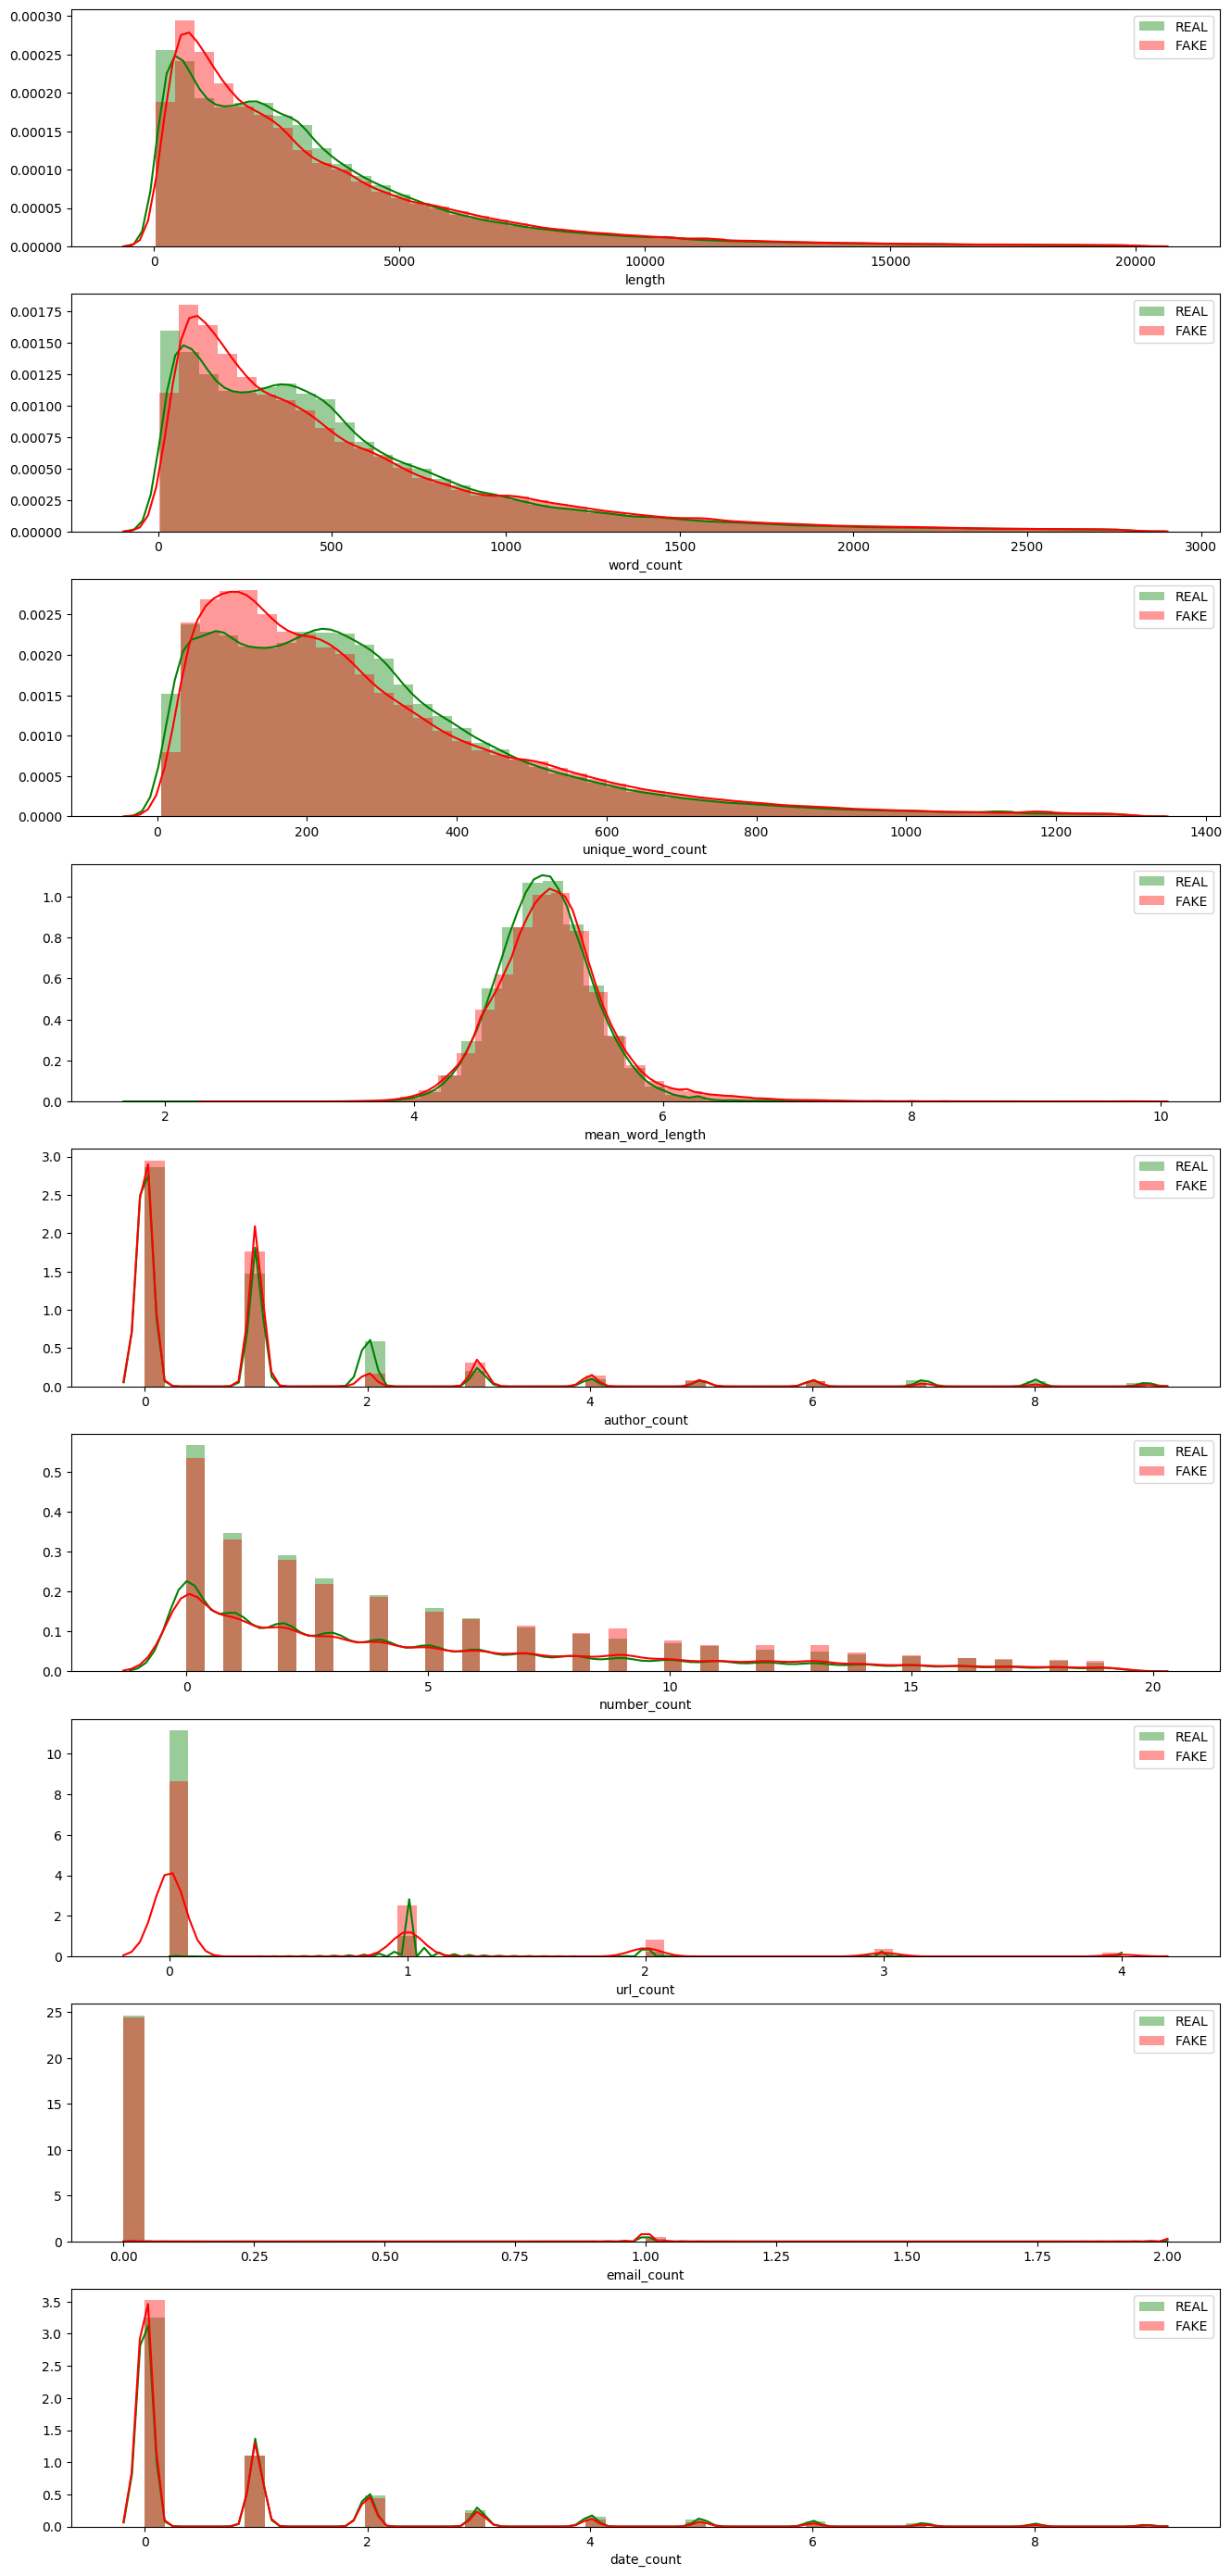

In [9]:
features = ['length','word_count','unique_word_count','mean_word_length','author_count',
            'number_count','url_count','email_count','date_count']
thresholds = [20000, 2800, 1300, 10, 10, 20, 5, 3, 10]

fig, axes = plt.subplots(nrows=len(features), figsize=(16,4*len(features)), dpi=100)
for i,f in enumerate(features):
    try: sns.distplot(df.loc[(df['b_type']=='REAL') & (df[f] < thresholds[i])][f],
                      label='REAL', color='green', ax=axes[i]) 
    except: pass
    try: sns.distplot(df.loc[(df['b_type']=='FAKE') & (df[f] < thresholds[i])][f],
                      label='FAKE', color='red', ax=axes[i]) 
    except: pass
for ax in axes:
    ax.legend()

No clear differences demonstrated